# Exploration
Complete EDA.ipynb first!

This notebook is a starting point for your own exploration of the data and should build upon your work and knowledge gained from EDA.ipynb. As a reminder, the goal is to identify the primary source(s) of failures and downtimes and, if possible, to assess the certainty of those conclusions.

Some questions you could explore are:
- Which Machines are responsible for 80% of overall Total Failures? Of overall Total Failure Downtime?
- Are there significant differences in the performances of Machines, Shifts, or Operators?
- If every minute of Cable Failure Downtime represents eight dollars of lost revenue and Other Failure Downtime represents five dollars then which Machines or Operators are responsible for the most lost revenue? 

In [1]:
# import libraries
import pandas as pd
import numpy as np

import os

from scipy.stats import ttest_ind

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# a simple theme that's better than the default
sns.set_theme(
    context='notebook',
    style='darkgrid', 
    palette='husl',
    rc={"figure.figsize":(24, 8)}
)

# set pandas display option
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# function to load & process operator_file
def get_operator_names(operator_file: str)->pd.DataFrame:
   
    """
    Load & process the contents of a file containing operator details.
    
    Params:
    operator_file - str; the path to the operator file.
    
    Returns:
    operator_df - pd.DataFrame; the extracted content of the operator file. The
    columns should include Operator Number, First Name, & Last Initial.
    """
    
    assert isinstance(operator_file, str), 'operator_file is not of type str.'
    
    # create a list of columns for reference
    columns = ['Operator Number', 'First Name', 'Last Initial']
    
    # load operator file
    operator = pd.read_csv(operator_file,
                           sep=r',', 
                           header = None,
                           names = columns,
                           delim_whitespace=True)
    
    # extract initial from last name
    operator['Last Initial'] = operator['Last Initial'].astype(str).str[0]
    
    # create an empty df to fill with contents of operator_file
    operator_df = pd.DataFrame(operator)
    
    return operator_df

In [3]:
# function to load and combine copper_file with operator_file
def load_combine(copper_file: str, operator_file: str)->pd.DataFrame:
    
    """
    Load, process & combine the contents of the copper_file and operator_df.
    
    Params:
    copper_file - str; the path to the copper file.
    operator_file - str; the path to the operator file.
    
    Returns:
    combined_df - pd.DataFrame; the extracted and combined content of the 
        two files. There should be 10 columns available after combining the
        two files and dropping any unecessary columns.   
    """
    
    assert isinstance(operator_file, str), 'operator_file path is not of type str.'
    assert isinstance(copper_file, str), 'copper_file path is not of type str.'
    
    # Store columns to reference in a list
    combination = ['Machine', 'Shift', 'Operator', 'Date']
    aggregation = ['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']
    
    # find absolute path to files
    abs_path_copper = os.path.abspath(copper_file)
    abs_path_operator = os.path.abspath(operator_file)
    
    # load and remove duplicates on copper_file
    copper_df = pd.read_excel(abs_path_copper, index_col = 0)
    
    # drop exact duplicates
    copper_df = copper_df.drop_duplicates()
    
    # create a new data frame that stores and aggregate duplicate 
    # records per Machine-Shift-Operator-Date combination
    dup_rows = copper_df.copy()
    
    dup_rows = dup_rows[dup_rows.duplicated(subset = combination, keep = False)]
    dup_rows = pd.DataFrame(dup_rows.groupby(combination)[aggregation].sum())
    dup_rows.reset_index(inplace = True)
    
    # drop duplicates within the column combination from copper_df
    # and concatenate dup_rows and copper_df
    
    copper_df = copper_df.drop_duplicates(subset = combination, keep = False)

    concat_dfs = [copper_df, dup_rows]
    
    copper_df = pd.concat(concat_dfs).reset_index(drop = True)
    
    print('There are {} rows in copper_file after dropping duplicates'.format(copper_df.shape[0]))
    print('')
    
    # load and pre-process operator_file
    
    operator_df = get_operator_names(abs_path_operator)

    # merge copper_df with operator_df using on 'Operator' = 'Operator Number'
    combined_df = copper_df.merge(operator_df, 
                                  how='left', 
                                  left_on='Operator', 
                                  right_on='Operator Number')

    # drop duplicated column & inspect the new combined table
    combined_df.drop('Operator', axis=1, inplace=True)
    
    combined_df = pd.DataFrame(combined_df)
    
    return combined_df

In [4]:
# function to feature engineer data frame
def feature_engineer(df: pd.DataFrame)->pd.DataFrame:
   
    """
    Engineer new features for the combined_df data frame.
    
    Params:
    df - DataFrame; the data frame used to add new features.
    
    Returns:
    combined_df - pd.DataFrame; a new data frame with newly created features.
        These features include 'Operator Name', Day of Week', 'Total Failure', 'Total Downtime', 
        and 'Total Failure Downtime'. A total of 13 features will be returned.
    """
    
    assert isinstance(df, pd.DataFrame), 'df is not a DataFrame.'
    
    cols = ['First Name', 'Last Initial']
    
    # create new features   
    df['Operator Name'] = df['First Name'] + '_' + df['Last Initial']
    df['Day of Week'] = df['Date'].dt.day_name()
    df['Total Failures'] = df['Cable Failures'] + df['Other Failures']
    df['Total Downtime min'] = df['Cable Failure Downtime'] + df['Other Failure Downtime']
    df['Total Downtime hr'] = round(df['Total Downtime min']/60, 2)
    
    # create an empty combined_df and fill with content with df
    combined_df = pd.DataFrame(df)
    
    combined_df.drop(cols, axis=1, inplace=True)
    
    return combined_df

In [5]:
# get the paths of the 2 files
copper_file = 'data/copper_production_v1.xlsx'
operator_file = 'data/operator_names.txt'

# combine 2 files using pre-defined function and print out the first 5 rows
df = load_combine(copper_file, operator_file)
df.head()

There are 145 rows in copper_file after dropping duplicates



,Machine,Shift,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Number,First Name,Last Initial
0,6,A,2020-11-15,0,0,1,60,12,Tad,S
1,6,B,2020-11-10,0,0,0,0,12,Tad,S
2,2,A,2020-11-06,1,10,3,150,2,Hugh,R
3,8,B,2020-11-16,3,175,0,0,13,Marcel,C
4,2,B,2020-11-09,0,0,1,20,1,Courtney,H


In [6]:
# feature engineer df dataframe using pre-defined function and print out first 5 rows
combined_df = feature_engineer(df)

combined_df.head()

,Machine,Shift,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Number,Operator Name,Day of Week,Total Failures,Total Downtime min,Total Downtime hr
0,6,A,2020-11-15,0,0,1,60,12,Tad_S,Sunday,1,60,1.00
1,6,B,2020-11-10,0,0,0,0,12,Tad_S,Tuesday,0,0,0.00
2,2,A,2020-11-06,1,10,3,150,2,Hugh_R,Friday,4,160,2.67
3,8,B,2020-11-16,3,175,0,0,13,Marcel_C,Monday,3,175,2.92
4,2,B,2020-11-09,0,0,1,20,1,Courtney_H,Monday,1,20,0.33


In [7]:
# inspect column datatype and check columns with missing values
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Machine                 145 non-null    int64         
 1   Shift                   145 non-null    object        
 2   Date                    145 non-null    datetime64[ns]
 3   Cable Failures          145 non-null    int64         
 4   Cable Failure Downtime  145 non-null    int64         
 5   Other Failures          145 non-null    int64         
 6   Other Failure Downtime  145 non-null    int64         
 7   Operator Number         145 non-null    int64         
 8   Operator Name           145 non-null    object        
 9   Day of Week             145 non-null    object        
 10  Total Failures          145 non-null    int64         
 11  Total Downtime min      145 non-null    int64         
 12  Total Downtime hr       145 non-null    float64   

In [8]:
# combined_df simple statistics on numeric variables
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Machine,145.0,5.910345,4.347600,1.0,2.0,5.0,8.00,17.0
Cable Failures,145.0,1.448276,1.353653,0.0,0.0,1.0,2.00,6.0
Cable Failure Downtime,145.0,52.862069,58.004265,0.0,0.0,35.0,75.00,295.0
Other Failures,145.0,0.551724,0.985527,0.0,0.0,0.0,1.00,9.0
Other Failure Downtime,145.0,48.344828,108.240433,0.0,0.0,0.0,45.00,690.0
Operator Number,145.0,12.993103,8.765856,1.0,6.0,12.0,19.00,32.0
Total Failures,145.0,2.000000,1.448179,0.0,1.0,1.0,3.00,9.0
Total Downtime min,145.0,101.206897,114.008826,0.0,30.0,60.0,130.00,690.0
Total Downtime hr,145.0,1.686966,1.900316,0.0,0.5,1.0,2.17,11.5


In [9]:
# inspect categorical variables
columns = ['Shift', 'Operator Name', 'Day of Week']

for col in combined_df[columns].columns:
    print(np.sort(combined_df[col].unique()))
    print('')

['A' 'B']

['Archy_B' 'Bennett_W' 'Byron_B' 'Christopher_G' 'Connie_M' 'Courtney_H'
 'David_S' 'Delmer_K' 'Diego_S' 'Dudley_S' 'Elliott_V' 'Eugene_W'
 'Floyd_G' 'Francisco_L' 'Fritz_M' 'Gonzalo_J' 'Harlan_B' 'Hess_H'
 'Hugh_R' 'Joesph_W' 'Jose_G' 'Lilly_Z' 'Lindsey_F' 'Marcel_C' 'Maurice_O'
 'Nichole_H' 'Norris_H' 'Rodney_G' 'Roland_M' 'Tad_S' 'Vince_F'
 'Woodrow_S']

['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']



In [10]:
# inspect date variable
print('There are {} unique dates in the dataset'.format(combined_df['Date'].nunique()))
print('')

# identify if any dates are missing in the data
date_max = combined_df['Date'].max()
date_min = combined_df['Date'].min()

print('The missing date(s): ')

pd.date_range(start = date_min, end = date_max).difference(combined_df['Date'])

There are 16 unique dates in the dataset

The missing date(s): 


DatetimeIndex(['2020-11-11'], dtype='datetime64[ns]', freq=None)

## Machine variable vs total failures/downtime

#### 1. What machine were used the most out of all machines?

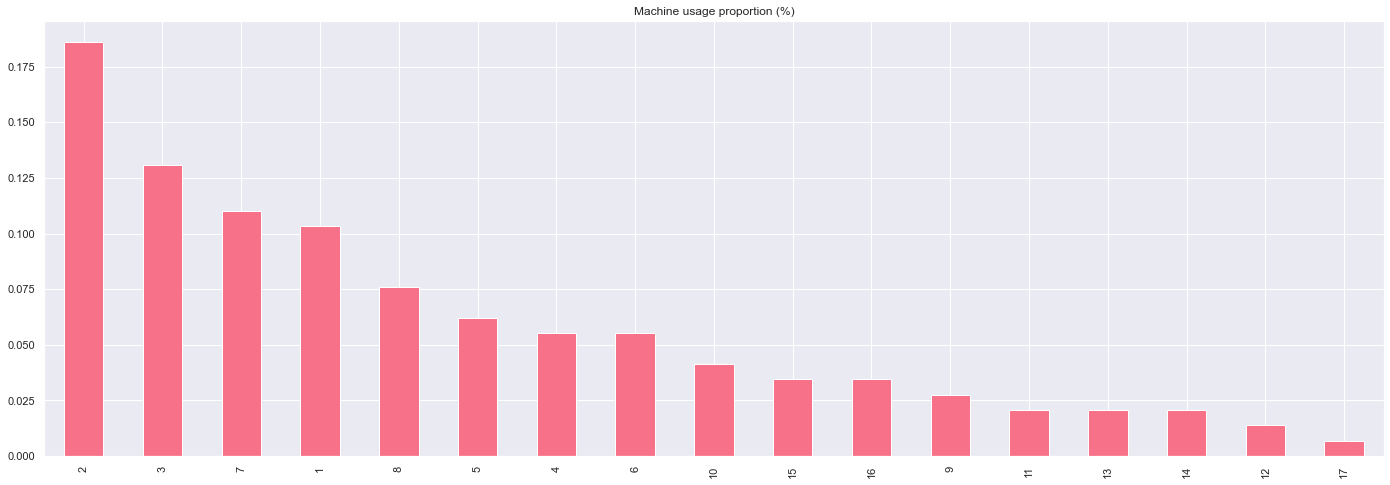

In [11]:
# create machine_proportion and draw a barchart
machine_proportion = combined_df['Machine'].value_counts(normalize = True)

machine_proportion.sort_values(ascending=False).plot(kind='bar',
                                                     title = 'Machine usage proportion (%)')

According to the above bar chart, machine number 2 was used the most out of all other machines (18.6% of total machine usage)

#### 2. What machines are responsible for the highest average failures and downtime?

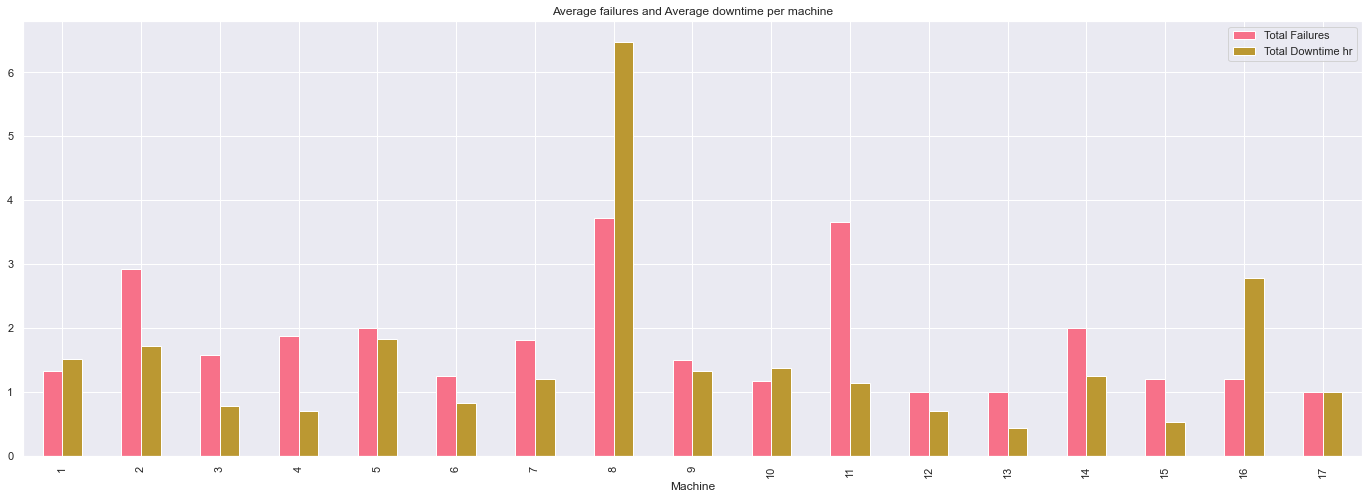

In [12]:
# create new dataframe that capture the relationship between machine and total failures/downtime
machine_failure_downtime = combined_df.groupby('Machine')['Total Failures', 'Total Downtime hr'].mean()

machine_failure_downtime.plot(kind='bar', 
                              title = 'Average failures and Average downtime per machine')

In [13]:
# proportion of failures over total failures per each machine
machine_failure = combined_df.groupby('Machine')['Total Failures'].sum()/combined_df['Total Failures'].sum()
machine_failure.sort_values(ascending = False).head()

Machine
2    0.272414
8    0.141379
3    0.103448
7    0.100000
1    0.068966
Name: Total Failures, dtype: float64

In [14]:
# proportion of downtime(hr) over total downtime(hr) per each machine
machine_downtime = combined_df.groupby('Machine')['Total Downtime hr'].sum()/combined_df['Total Downtime hr'].sum()
machine_downtime.sort_values(ascending = False).head()

Machine
8    0.291321
2    0.190794
1    0.093373
7    0.079065
5    0.067413
Name: Total Downtime hr, dtype: float64

Even though machine 2 and 3 were ultilized the most, machine 8 caused the longest downtime. This means machines associated with the highest number of failures don't necessarily caused the longest downtime.

#### 3. What machine should be focused on?

In [15]:
# create avg downtime/failure metric for each machine
machine_dt_per_fl = combined_df[['Machine', 'Total Failures', 'Total Downtime min']]

machine_dt_per_fl = machine_dt_per_fl.groupby('Machine')[['Total Failures','Total Downtime min']].sum()

machine_dt_per_fl['Avg Downtime(min)/Failure'] = machine_dt_per_fl['Total Downtime min']/ machine_dt_per_fl['Total Failures']

machine_dt_per_fl.sort_values(by = 'Avg Downtime(min)/Failure', ascending = False)

,Total Failures,Total Downtime min,Avg Downtime(min)/Failure
Machine,,,
16,6,835,139.166667
8,41,4275,104.268293
10,7,495,70.714286
1,20,1370,68.500000
17,1,60,60.000000
5,18,990,55.000000
9,6,320,53.333333
12,2,85,42.500000
7,29,1160,40.000000


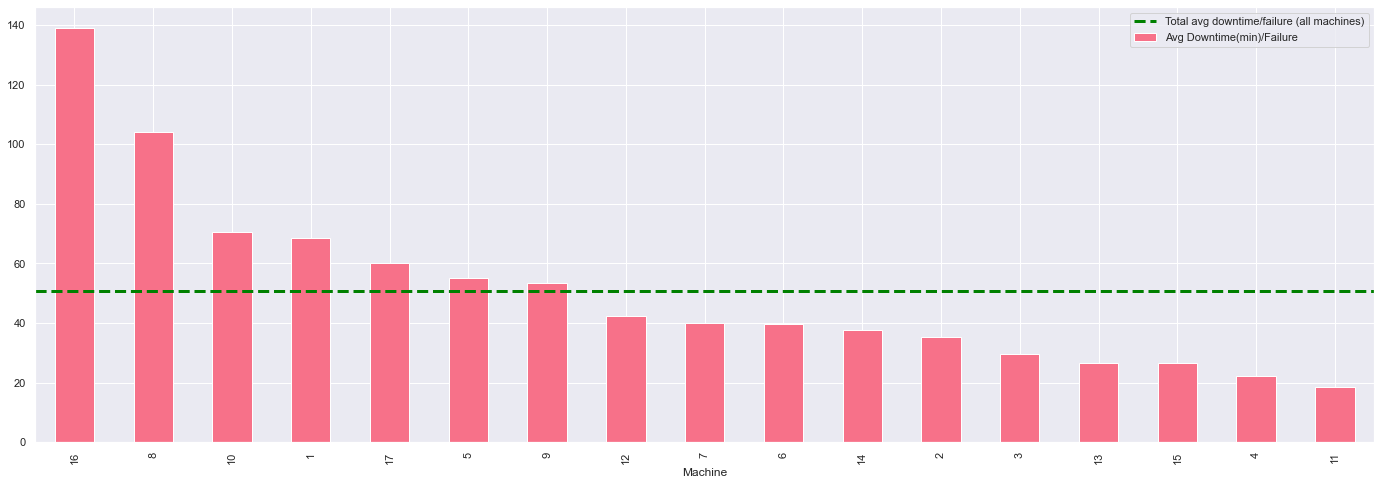

In [16]:
# plot avg downtime(min)/failure per machine vs average downtime(min)/failure per all machines
machine_dt_per_fl['Avg Downtime(min)/Failure'].sort_values(ascending = False).plot(kind = 'bar')

plt.axhline(combined_df['Total Downtime min'].sum()/combined_df['Total Failures'].sum(), 
            c='green', 
            linestyle='--', 
            linewidth=3,
            label = 'Total avg downtime/failure (all machines)')

plt.legend()
plt.show()

This is interesting! 

From an utilization perspective, the manufacturer would probably want to fix/maintain/service machine 2 and machine 3 the most because they are the highest ultilized machines of all in the shop.

However, when it comes to performance, machine 16 and machine 8 need to be focused on the most because they tend to have a longer downtime whenever they fail.

#### 4. If every minute of Cable Failure Downtime represents eight dollars of lost revenue and Other Failure Downtime represents five dollars then which Machines are responsible for the most lost revenue?

In [17]:
# create revenue by machine df and calculate lost revenue
rev_by_machine = combined_df[['Machine', 'Cable Failure Downtime', 'Other Failure Downtime']]

rev_by_machine['Lost Revenue'] = (combined_df['Cable Failure Downtime'] * 8) + (combined_df['Other Failure Downtime'] * 5)

rev_by_machine.head()

,Machine,Cable Failure Downtime,Other Failure Downtime,Lost Revenue
0,6,0,60,300
1,6,0,0,0
2,2,10,150,830
3,8,175,0,1400
4,2,0,20,100


In [18]:
# machines associated with the most amount of lost revenue 
rev_by_machine.groupby('Machine')['Lost Revenue'].sum().sort_values(ascending = False).head(2)

Machine
8    25650
2    18665
Name: Lost Revenue, dtype: int64

Based on the hypothesis above, machine 8 and machine 2 were responsible the the most amount of lost revenue (around 44 thousand dollars)

## Shift variable vs total failures/downtime

#### 1. What shift is associated with the most amout of total failures/downtime?

In [19]:
# inspect shift proportion
shift_proportion= combined_df['Shift'].value_counts(normalize = True)
shift_proportion

A    0.510345
B    0.489655
Name: Shift, dtype: float64

The number of shifts were well distributed between shift A and shift B with shift A accounted for 51% of the total number of shifts, and shift B accounted for 49%, respectively.

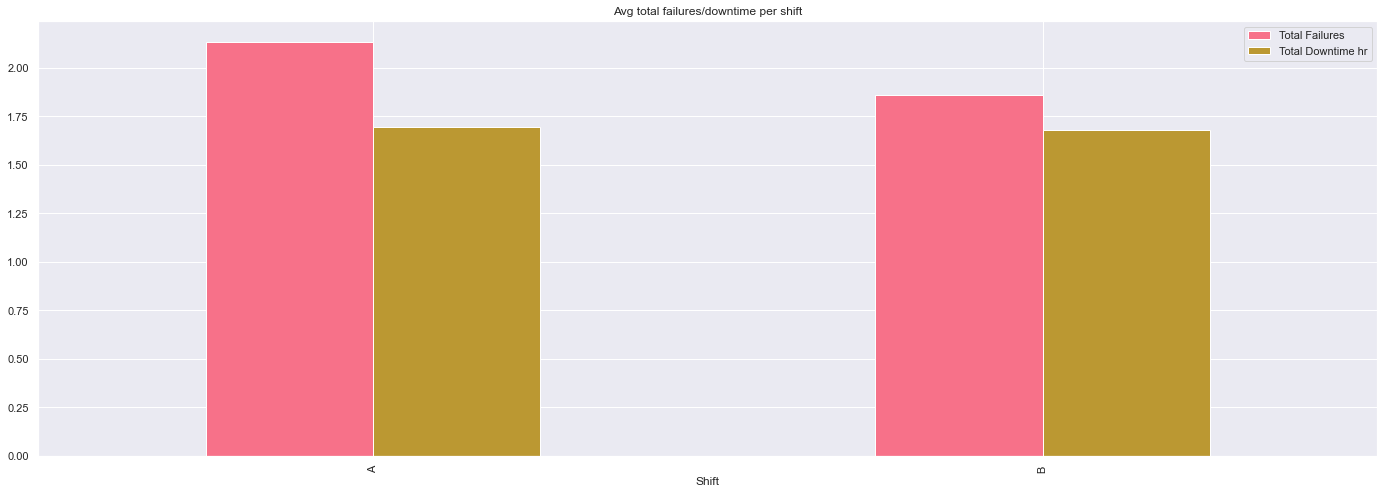

In [20]:
# plot the relationship between shift vs average total failures/downtime
combined_df.groupby('Shift')['Total Failures', 'Total Downtime hr'].mean().plot(kind='bar',
                                                                               title = 'Avg total failures/downtime per shift')

According to the bar chart above, shift A and shift B had very similar average downtime per shift.

When it comes to the number of failures, shift A's average total failures was slightly higher than that of shift B.
Is the difference in the mean of failures of the 2 shifts statistically significant enough to indicate a relationship between shift and total failures?

Let's use t-test in the below section to find out.

#### 2. Is the mean failure/downtime of shift A statistically different from the mean failure/downtime of shift B?

A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups; In other words it lets you know if those differences (measured in means) could have happened by chance.

The t score is a ratio between the difference between two groups and the difference within the groups. The larger the t score, the more difference there is between groups. The smaller the t score, the more similarity there is between groups. A t score of 3 means that the groups are three times as different from each other as they are within each other. 

Every t-value has a p-value to go with it. A p-value is the probability that the results from your sample data occurred by chance. Low p-values (<=0.05) are good as they indicate your data did not occur by chance. 

We will use the same method to on mean total failures and mean total downtime by shift to check these variables statistical significance.

In [21]:
# calculate t-test scores for mean Total Failures and 
# mean Total Downtime min between shift A and shift B
for i in ['Total Failures', 'Total Downtime min']:
    
    shift_df = combined_df.copy()

    shift_df = shift_df[['Shift', i]]

    shift_A = shift_df[shift_df['Shift']=='A']
    shift_B = shift_df[shift_df['Shift']=='B']
    
    print('t-test scores for ' + i)
    print(ttest_ind(shift_A[i], shift_B[i]))
    print('')

t-test scores for Total Failures
Ttest_indResult(statistic=1.1484101412201047, pvalue=0.2527167011230567)

t-test scores for Total Downtime min
Ttest_indResult(statistic=0.051824329920562885, pvalue=0.9587409919825142)



We have a small t-test score, with a p-value > 0.05 for both Total Failures and Total Downtime min, which indicates the variance in mean total failures and the variance in mean total downtime between shift A and shift B are not statistically significant enough to explain the relationship between shift and total failures/downtime.

## Operator variable vs total failures/downtime

#### 1. What operators were associated with the highest number of failure/downtime?

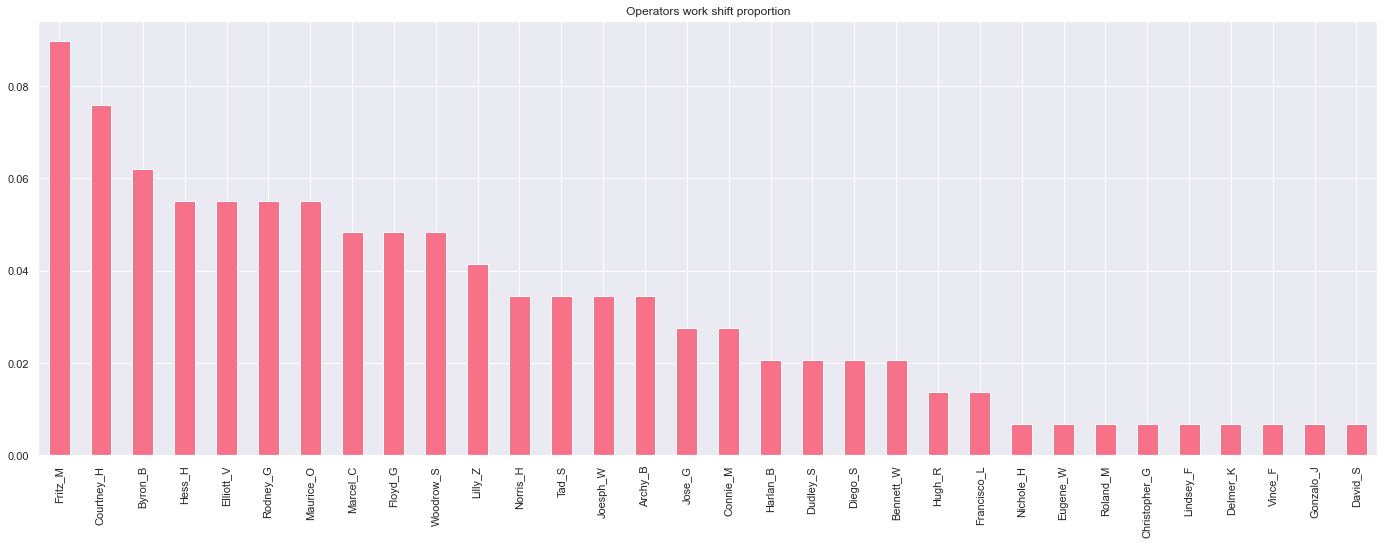

In [22]:
# Which operator worked the most?
operator_proportion = combined_df['Operator Name'].value_counts(normalize = True)

operator_proportion.sort_values(ascending=False).plot(kind='bar',
                                            title = 'Operators work shift proportion') 

According to the bar chart above, Fritz_M and Courtney_H worked the highest proprotion of total shifts, but does that mean they are associated with the highest number of failures and downtime?

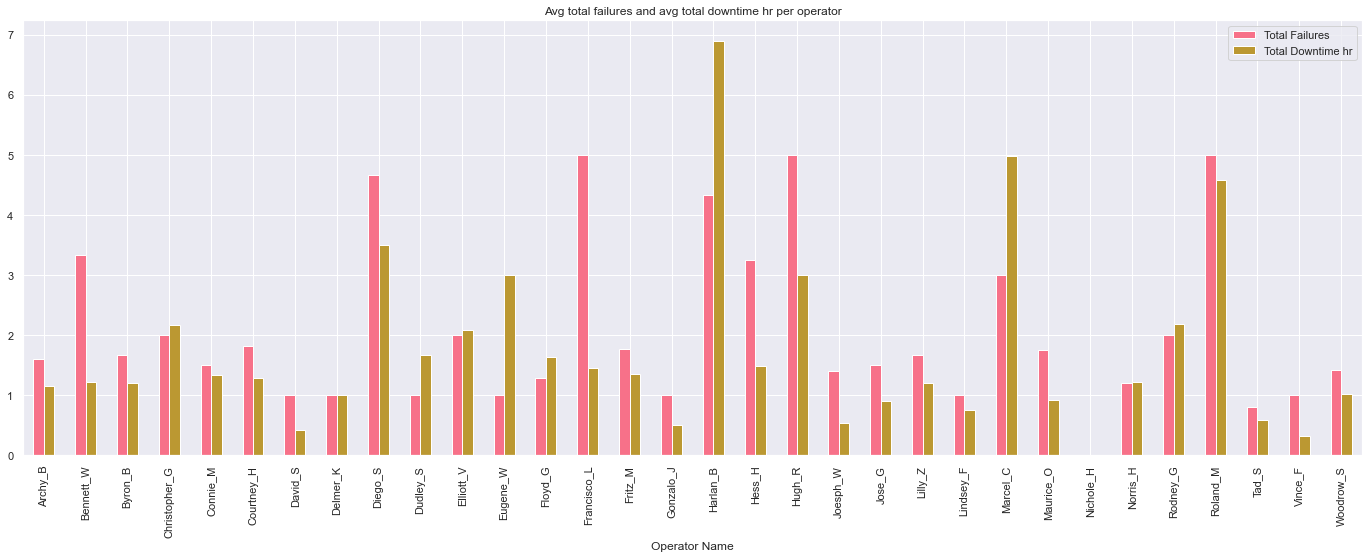

In [23]:
# plot barchart showing the average total failures and average downtime per each operator
combined_df.groupby('Operator Name')[['Total Failures', 'Total Downtime hr']].mean().plot(kind='bar',
                                                                                         title = 'Avg total failures and avg total downtime hr per operator')

According to the barchart above, even though Francisco_L, Hugh_R, and Roland_M had the highest average total failures between all operators, it is Harlan_B and Marcel_C that had the longest average total downtime (hr) of all others.

#### 2. If every minute of Cable Failure Downtime represents eight dollars of lost revenue and Other Failure Downtime represents five dollars then which Operators are responsible for the most lost revenue?

In [24]:
# create revenue by operator df and calculate lost revenue
rev_by_operator = combined_df[['Operator Name', 'Cable Failure Downtime', 'Other Failure Downtime']]

rev_by_operator['Lost Revenue'] = (combined_df['Cable Failure Downtime'] * 8) + (combined_df['Other Failure Downtime'] * 5)

rev_by_operator.head()

,Operator Name,Cable Failure Downtime,Other Failure Downtime,Lost Revenue
0,Tad_S,0,60,300
1,Tad_S,0,0,0
2,Hugh_R,10,150,830
3,Marcel_C,175,0,1400
4,Courtney_H,0,20,100


In [25]:
# operator associated with the most amount of lost revenue 
rev_by_operator.groupby('Operator Name')['Lost Revenue'].sum().sort_values(ascending = False).head(2)

Operator Name
Marcel_C    12890
Fritz_M      7900
Name: Lost Revenue, dtype: int64

According to the above results, Marcel_C and Fritz_M were liable for the highest amount of lost revenue (about $20.8k) 

## What features are most the predictive when it comes to predicting total downtime?

In [26]:
# create new data frame that captures variables of interest
variables = ['Machine', 'Shift', 'Operator Name', 'Total Downtime hr']

new_df = combined_df[variables]
new_df.head()

,Machine,Shift,Operator Name,Total Downtime hr
0,6,A,Tad_S,1.00
1,6,B,Tad_S,0.00
2,2,A,Hugh_R,2.67
3,8,B,Marcel_C,2.92
4,2,B,Courtney_H,0.33


In [27]:
# encode categorical variables
encode_variables = ['Shift', 'Operator Name']

for i in encode_variables:
    encoder = LabelEncoder()
    new_df[i] = encoder.fit_transform(new_df[i])
    print('complete {} encoding process '.format(i))

complete Shift encoding process 
complete Operator Name encoding process 


In [28]:
# scale new_df using StandardScaler
scaler = StandardScaler()

new_df = pd.DataFrame(scaler.fit_transform(new_df), columns = variables)

new_df.head()

,Machine,Shift,Operator Name,Total Downtime hr
0,0.020693,-0.979520,1.471613,-0.362754
1,0.020693,1.020908,1.471613,-0.890806
2,-0.902544,-0.979520,0.274661,0.519094
3,0.482312,1.020908,0.818730,0.651107
4,-0.902544,1.020908,-1.139918,-0.716549


In [29]:
# split the dataset into explanatoru variables and target variable
X = new_df.iloc[:, :-1] # explanatory variables
Y = new_df['Total Downtime hr'] # target variable

print(X.shape, Y.shape)

(145, 3) (145,)


In [30]:
# define regressor and fit to the data
regressor = ExtraTreeRegressor(random_state=0)
regressor.fit(X, Y)

ExtraTreeRegressor(random_state=0)

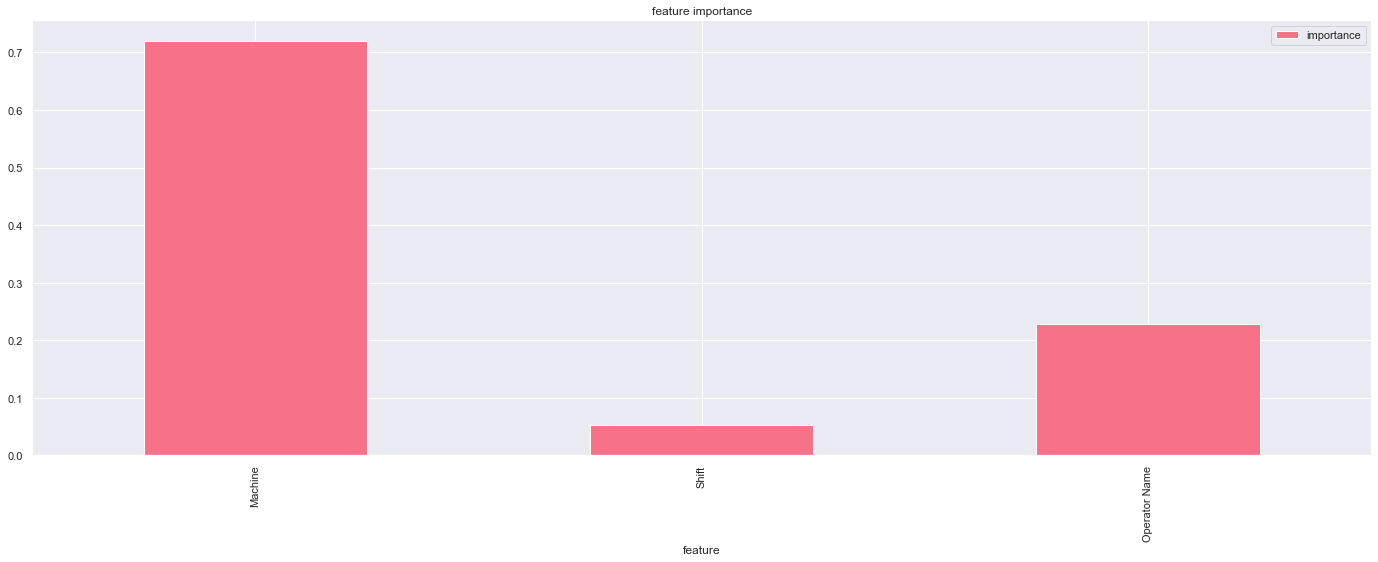

In [31]:
# feature importance
importance = pd.DataFrame(regressor.feature_importances_).rename(columns = {0:'importance'}).reset_index(drop = True)

feature = pd.DataFrame(X.columns).rename(columns = {0:'feature'}).reset_index(drop = True)

feature_importance = pd.DataFrame(pd.concat([feature, importance], axis=1))

# plot feature importance
feature_importance.plot(x = 'feature', 
                        y = 'importance', 
                        kind='bar',
                        title = 'feature importance')

According to the bar chart above, machine is the most predictive feature when it comes to predicting total downtime. Shift variable, as both seen in the chart and t-test performance above, is not an important feature when it comes to predicting total downtime, and so is operator name.

# End